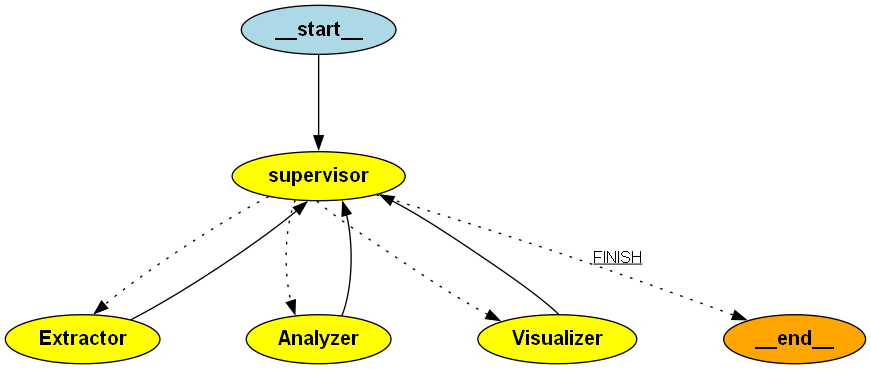

InvalidUpdateError: Must write to at least one of ['messages', 'next']

In [9]:
from Agent_Creation import create_agent
from Node_Creation import agent_node
import functools
import RequestAndInsertionTool
from LLM_Initialization import llm_initialization
from PythonREPLTool import get_REPL_Tool
from Supervisor import Creation_Of_Supervisor_Chain,get_members
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import BaseMessage, HumanMessage
from Graph_Display import display_graph
from QueryGenerator import get_sql_flow
from typing import Annotated,Sequence, TypedDict
import operator



# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str




## Creation of Extractor Agent
extracter_agent = create_agent(
        llm_initialization(), 
        [RequestAndInsertionTool.RequestAndInsertTool], 
        """
        you're a helpful assistant responsible for extracting the information from the URL 
        and the extracted details will be inserted to the database of the Person Table using psycopg2"""
    )
extracter_node = functools.partial(agent_node, agent=extracter_agent, name="Extractor")


## Creation of Visualizer Agent

visualizer_agent = create_agent(
    llm_initialization(),
    [get_REPL_Tool()],
    "You may generate safe python code to visualize data and generate bar plot charts using matplotlib.",
)

visualizer_node = functools.partial(agent_node, agent=visualizer_agent, name="Visualizer")


## Creation of SQL Analyzer Agent
app = get_sql_flow()

## Creation of Supervisor

workflow = StateGraph(AgentState)
workflow.add_node("Extractor", extracter_node)
workflow.add_node("Analyzer", app)
workflow.add_node("Visualizer", visualizer_node)
workflow.add_node("supervisor", Creation_Of_Supervisor_Chain(llm_initialization()))


## Adding the Edges between the Nodes of the graph

members = get_members()

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)


# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

from IPython.display import display, Image

png_data = graph.get_graph().draw_png()


image = Image(data=png_data, width=300, height=300)

display(image)




## Graph Stream
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=
                         
                         "Analyze the number of people based on their gender," 
                         "then visualize the results using a bar graph over it"
                        "and once you code it up,finish."
                         )
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

